# Benchmark Modell SPS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../..')
from helper.lazy_regression import TooLazyForRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [3]:
data = pd.read_table('../../data/data_mpa.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [4]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_M01,centroid_frequency2_M01,centroid_frequency_M02,centroid_frequency2_M02,centroid_frequency_M03,centroid_frequency2_M03,centroid_frequency_M04,centroid_frequency2_M04,median_freq_M01,median_freq_M02,median_freq_M03,median_freq_M04,flash_ind_M01,flash_ind_M02,flash_ind_M03,flash_ind_M04,cv_M01,cv_M02,cv_M03,cv_M04,iqa_M01,iqa_M02,iqa_M03,iqa_M04,mab_M01,mab_M02,mab_M03,mab_M04,imp_M01,imp_M02,imp_M03,imp_M04,len_M01,len_M02,len_M03,len_M04
0,12,2.4,2513.790973,2501.778917,2930.137074,3107.080795,2677.806164,2992.267923,2552.141012,2963.618340,2459.731207,3117.579309,3077.091931,3080.477558,0.002895,0.00399,0.003336,0.004129,0.556826,1.165440,1.015913,1.305203,0.000016,5.257369e-05,1.461929e-05,2.487844e-05,0.139785,0.290108,0.151263,0.182237,0,1,0,0,42,42,42,42
1,14,1.7,2656.734602,2825.463736,2904.310040,3073.865547,2839.883811,3034.379307,2355.403063,2321.383264,2817.582730,3085.207503,3046.883562,2636.896334,0.001214,0.00248,0.002583,0.003359,0.773513,0.789951,0.694314,0.535843,0.003530,7.479831e-07,3.542450e-07,2.025442e-07,3.005457,0.037943,0.027260,0.019468,5,0,0,0,52,52,52,52


## Select Best Feature for Benchmark

In [6]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [7]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.95s/it]


In [8]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,0.534309
1,1,0.538646


In [9]:
tmp_ = tmp.groupby('n_feature').mean()

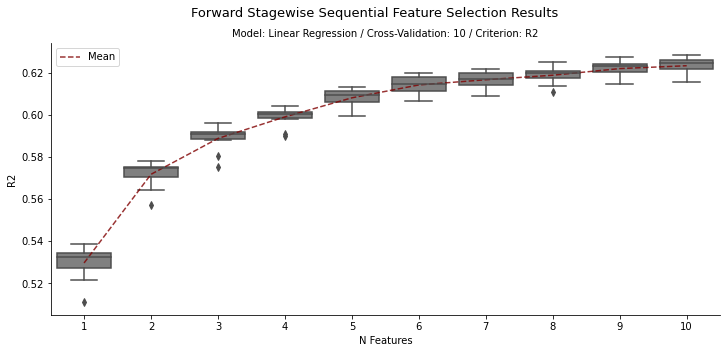

In [12]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [17]:
n_features = 5
best_feature_dict[n_features]

array(['centroid_frequency_M01', 'centroid_frequency2_M04',
       'median_freq_M04', 'cv_M04', 'imp_M04'], dtype=object)

In [18]:
X_best = X[best_feature_dict[n_features]]

## Hyperparameter 

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.60903539 0.6127885  0.60575239 0.59960816 0.60993733 0.6130987
 0.60712967 0.61114504 0.610825   0.60071343]
Mean Resutls:  0.6080033611622575
